# Experiment 3

Model the equation of SHM :

$$ x = A cos(\omega t) $$

In [2]:
from kan.MultKAN import MultKAN



In [3]:
from kan.utils import create_dataset, augment_input
from sympy import symbols, cos
import torch

# Set seed and precision
seed = 1
torch.manual_seed(seed)
torch.set_default_dtype(torch.float64)

# Step 1: Define input variables
input_variables = A, omega, t = symbols('A omega t')

# Step 2: Define auxiliary variable
theta = omega * t
cos_theta = cos(theta)

aux_vars = (theta , cos_theta)


# Step 3: Define function f: input → output (s = A cos(ωt))
f = lambda x: x[:, [0]] * torch.cos(x[:, [1]] * x[:, [2]])

# Step 4: Create dataset
dataset = create_dataset(
    f,
    n_var=3,
    ranges=[
        [1, 10],       # A
        [0.5, 5.0],    # omega
        [0, 2 * 3.1416]  # t (approx 0 to 2π)
    ]
)

# Step 5: Add auxiliary variable θ = ωt
dataset = augment_input(input_variables, aux_vars, dataset)
input_variables = aux_vars + input_variables  # Optional reordering for interpretability


In [4]:
model = MultKAN(width=[5,[0,1]], mult_arity=2, grid=3, k=3, seed=seed)

checkpoint directory created: ./model
saving model version 0.0


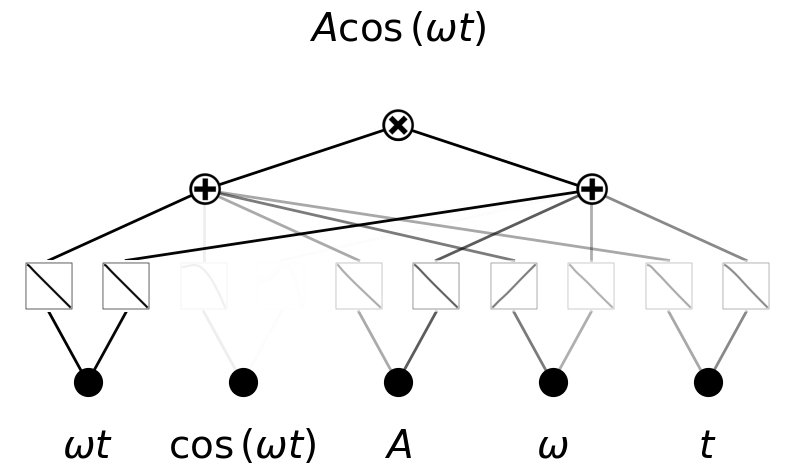

In [5]:
model(dataset['train_input'])
model.plot(in_vars=input_variables, out_vars=[A * cos(theta)], scale=1.0, varscale=0.7)

In [6]:
model.fit(dataset, steps=50, lamb=1e-5, lamb_coef=1.0);

| train_loss: 1.03e-02 | test_loss: 1.10e-02 | reg: 1.02e+01 | : 100%|█| 50/50 [00:08<00:00,  6.17it

saving model version 0.1


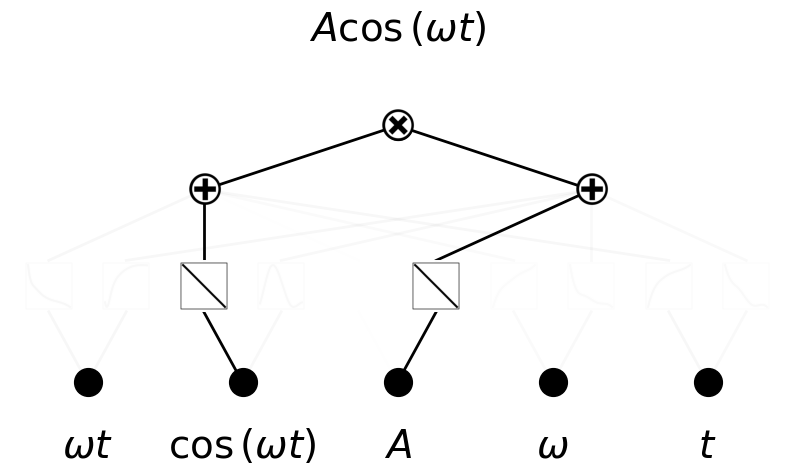

In [7]:
model.plot(in_vars=input_variables, out_vars=[A * cos(theta)], scale=1.0, varscale=0.7)

In [8]:
model = model.prune(edge_th=5e-2)

saving model version 0.2


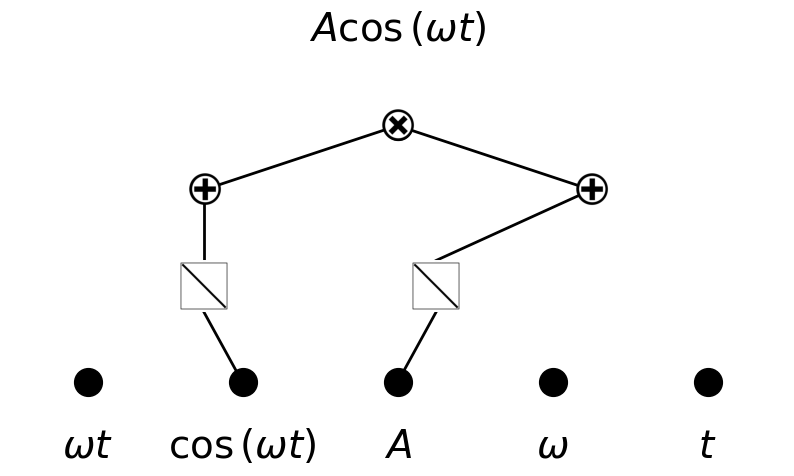

In [9]:


model.plot(in_vars=input_variables, out_vars=[A * cos(theta)], scale=1.0, varscale=0.7)


In [10]:
model.fit(dataset, steps=100, lamb=0e-3);

| train_loss: 2.45e-03 | test_loss: 2.72e-03 | reg: 5.38e+00 | : 100%|█| 100/100 [00:08<00:00, 12.04


saving model version 0.3


In [11]:
model.auto_symbolic()

fixing (0,0,0) with 0
fixing (0,0,1) with 0
fixing (0,1,0) with x, r2=0.9999999985310919, c=1
fixing (0,1,1) with 0
fixing (0,2,0) with 0
fixing (0,2,1) with x, r2=0.9999979006822949, c=1
fixing (0,3,0) with 0
fixing (0,3,1) with 0
fixing (0,4,0) with 0
fixing (0,4,1) with 0
saving model version 0.4


In [12]:
sf = model.symbolic_formula(var=input_variables)[0][0]
sf

1.0*(3.13515917041429e-6 - 0.206815750073007*A)*(-4.83517187477005*cos(omega*t) - 3.57239463788517e-6)

In [14]:
from kan.utils import ex_round
from kan import nsimplify

nsimplify(ex_round(ex_round(ex_round(sf,6),3),3))

A*cos(omega*t)

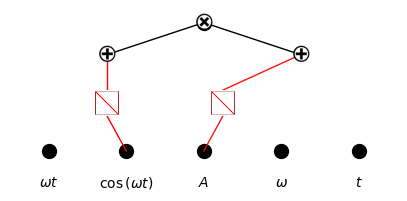

In [15]:
model.plot(metric='forward_u' , in_vars=input_variables , varscale= 0.5)

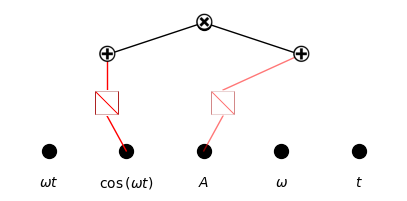

In [16]:
model.plot(metric='forward_n' , in_vars=input_variables , varscale= 0.5)


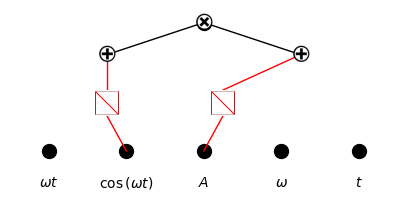

In [17]:
model.plot(metric='backward' , in_vars=input_variables , varscale= 0.5)


In [18]:
import torch.nn as nn
import torch.optim as optim

# Step 1: Extract input and output tensors
X = dataset['train_input']
y = dataset['train_label']

# Step 2: Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.net(x)

mlp = MLP(X.shape[1])

# Step 3: Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Step 4: Training loop
losses = []
for epoch in range(500):
    mlp.train()
    optimizer.zero_grad()
    y_pred = mlp(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


Epoch 0: Loss = 20.457803
Epoch 50: Loss = 11.174019
Epoch 100: Loss = 1.495002
Epoch 150: Loss = 0.362839
Epoch 200: Loss = 0.207998
Epoch 250: Loss = 0.138472
Epoch 300: Loss = 0.096328
Epoch 350: Loss = 0.067542
Epoch 400: Loss = 0.048350
Epoch 450: Loss = 0.035850


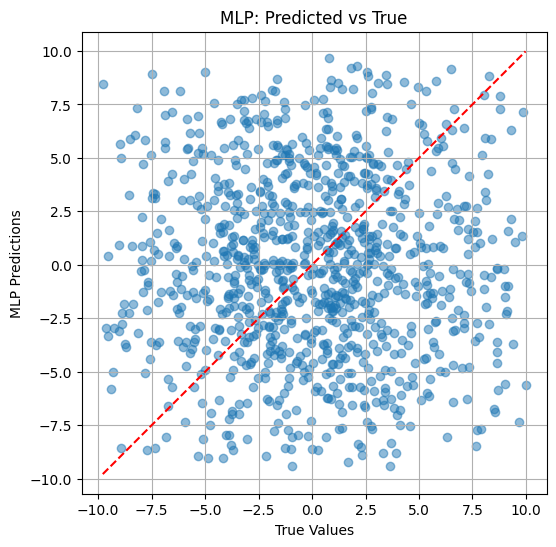

In [19]:
import matplotlib.pyplot as plt

# Convert to numpy
y_test_np = dataset['test_label'].detach().numpy()
y_pred_np = y_pred.cpu().detach().numpy()

plt.figure(figsize=(6,6))
plt.scatter(y_test_np, y_pred_np, alpha=0.5)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("MLP Predictions")
plt.title("MLP: Predicted vs True")
plt.grid(True)
plt.axis("equal")
plt.show()
